# Chapter 5: Advanced Prompt Engineering
    Input/Output Validation
    
    Chain of Thought Prompting (do a JSON output and show with and without a "step_by_step_reasoning" and try reasoning before and after the answer)
    
    Prompt Chaining Workflows (fine-tuned star classify to filter for good/bad and then if bad, do this, if good, other)
    
    Preventing against Prompt Injection Attacks (prompt against it or Input/Output Validation)
    Building a bot that can execute code on our behalf
    
    ### extra
    
    dynamic k shot using embeddings?

5장: 고급 프롬프트 엔지니어링
    입력/출력 유효성 검사
    
    생각의 연쇄 프롬프트(JSON 출력을 수행하여 "step_by_step_reasoning" 유무에 따라 표시하고 답변 전후에 추론을 시도)
    
    프롬프트 연쇄 워크플로(미세 조정된 별 분류를 통해 좋음/나쁨을 필터링한 다음 나쁘면 이렇게, 좋으면 저렇게, 기타)
    
    프롬프트 인젝션 공격 방지(프롬프트에 대한 프롬프트 또는 입출력 유효성 검사)
    우리를 대신하여 코드를 실행할 수 있는 봇 구축
    
    ### 추가
    
    임베딩을 사용한 동적 K 샷?



# 0. VIT, VILT 설명

VIT(Vision Transformer)와 VILT(Vision-Language Transformer) 모델은 컴퓨터 비전과 자연어 처리 분야에서 주목받고 있는 모델입니다.

1. VIT(Vision Transformer)
- 트랜스포머 아키텍처를 컨볼루션 신경망 대신 이미지 데이터에 직접 적용한 모델입니다.
- 이미지를 패치(patch)로 분할하고, 각 패치를 토큰으로 취급하여 트랜스포머에 입력합니다.
- 자가 주의(self-attention) 메커니즘을 통해 이미지 내 패치 간의 관계를 효과적으로 학습할 수 있습니다.
- 대량의 데이터와 엄청난 계산 자원이 필요하지만, 컨볼루션 신경망 대비 우수한 성능을 보입니다.

2. VILT(Vision-Language Transformer) 
- 단일 스트림 통합 모델로, 이미지와 텍스트를 동시에 처리할 수 있습니다.
- 이미지는 VIT와 유사하게 패치로 분할되고, 텍스트는 토큰화됩니다.
- 이미지 패치와 텍스트 토큰이 단일 시퀀스로 연결되어 트랜스포머에 입력됩니다.
- 멀티모달 인코더를 통해 이미지와 텍스트의 상호 관계를 효과적으로 학습합니다.
- 시각 질의 응답, 이미지 캡셔닝, 멀티모달 retrieval 등 다양한 태스크에 활용됩니다.

이들 모델은 컨볼루션 신경망의 한계를 뛰어넘어 비전과 언어 분야에서 새로운 패러다임을 열고 있습니다.

# 1. 초기화 및 기본 함수 작성

In [1]:
import os
import openai
import cohere
from openai import OpenAI
import anthropic

import json
from transformers import pipeline
import numpy as np

import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch

from transformers import ViltForQuestionAnswering, ViltProcessor
from transformers import BlipProcessor, BlipForQuestionAnswering
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [2]:
co = cohere.Client(os.getenv('COHERE_API_KEY'))
openai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)
anthropic_client = anthropic.Anthropic()

In [3]:
def test_prompt_openai(prompt, suppress=False, model='gpt-3.5-turbo', **kwargs):
    
    if model == 'babbage-002' or model == 'davinci-002' or model == 'gpt-3.5-turbo-instruct' :
        response = openai_client.completions.create(
            model=model,
            prompt=prompt,
            max_tokens=1000,
            **kwargs
        ).choices[0].text
    else:
        chat_completion = openai_client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model=model,
            **kwargs
        )
        response = chat_completion.choices[0].message.content
    
    if not suppress:
        print(f'\nMODEL:OpenAI {model}\nPROMPT:\n------\n{prompt}\n------\nRESPONSE\n------\n{response}')
    return response


In [4]:
def test_prompt_cohere(prompt, suppress=False, model='command-xlarge-nightly', **kwargs):
    response = co.generate(
        model=model,
        prompt=prompt,
        max_tokens=256,
        **kwargs,
      ).generations[0].text
    if not suppress:
        print(f'\nMODEL:Cohere {model}\nPROMPT:\n------\n{prompt}\n------\nRESPONSE\n------\n{response}')
    return response

In [5]:
def test_prompt_anthropic(prompt, suppress=False, model='claude-3-opus-20240229', max_tokens=3000, temperature=0, **kwargs):
    chat_completion = anthropic_client.messages.create(
        model=model,
        max_tokens=max_tokens,
        temperature=temperature,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt,
                    }
                ]
            }
        ],
        **kwargs
    )
    answer = chat_completion.content[0].text
    if not suppress:
        print(f'\nMODEL:Anthropic {model}\nPROMPT:\n------\n{prompt}\n------\nRESPONSE\n------\n{answer}')
    return answer

# 2. ViT 및 GPT2를 사용하여 수신 이미지 캡션하기

"image-to-text" 태스크를 위한 pipeline을 생성하고 있습니다. 이 태스크는 이미지를 입력받아 해당 이미지를 설명하는 텍스트를 생성하는 것입니다. 

모델로는 "nlpconnect/vit-gpt2-image-captioning" 모델을 사용하고 있습니다. 이 모델은 ViT(Vision Transformer)와 GPT-2(Generative Pre-trained Transformer 2)를 결합한 모델로, 이미지 캡셔닝(captioning) 태스크에 특화되어 있습니다.

즉, 이 코드는 Hugging Face의 사전 학습된 ViT-GPT2 모델을 사용하여, 주어진 이미지를 설명하는 텍스트를 생성하는 pipeline을 생성하는 것입니다. 생성된 pipeline 객체인 image_to_text를 통해 이미지를 입력하면, 해당 이미지를 설명하는 텍스트를 출력받을 수 있습니다.

In [6]:
from transformers import pipeline

image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


네, 주신 코드를 설명드리겠습니다.

1. url 변수에 이미지 파일의 경로나 URL을 할당합니다. 여기서는 '../images/smoke_in_the_distance.png'라는 로컬 파일 경로를 사용하고 있습니다.

2. image_to_text 함수에 url을 전달하여 이미지 캡션을 생성합니다. 생성된 캡션은 리스트 형태로 반환되며, 첫 번째 요소의 'generated_text' 키에 해당하는 값을 caption 변수에 할당합니다.

3. Image.open 함수를 사용하여 이미지 파일을 엽니다. 만약 url이 'https'를 포함하는 경우, requests.get을 사용하여 이미지 데이터를 가져오고, stream=True로 설정하여 데이터를 청크 단위로 받아옵니다. 그렇지 않은 경우, 로컬 파일 경로를 직접 전달합니다.

4. np.array 함수를 사용하여 이미지를 NumPy 배열로 변환하여 image_array 변수에 할당합니다.

5. Matplotlib의 plt.imshow 함수를 사용하여 이미지를 화면에 표시합니다.

6. plt.title 함수를 사용하여 생성된 캡션을 이미지 위에 제목으로 표시합니다.

7. plt.axis('off')를 호출하여 그래프의 축을 숨깁니다.

8. plt.show 함수를 호출하여 이미지와 캡션을 화면에 출력합니다.

이 코드는 주어진 이미지 파일을 읽어들이고, 이전에 생성한 image_to_text pipeline을 사용하여 이미지를 설명하는 캡션을 생성합니다. 그런 다음, Matplotlib을 사용하여 이미지와 생성된 캡션을 함께 화면에 출력합니다.

/Users/wlkim/anaconda3/envs/quick-start-guide-to-llms/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


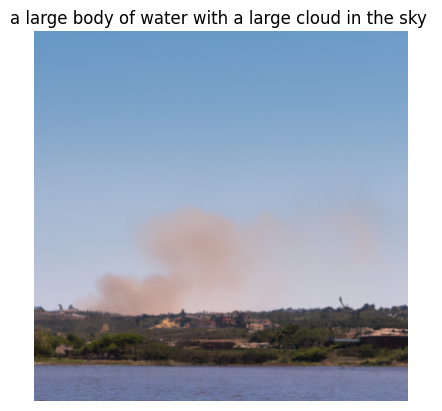

In [7]:
url = '../images/smoke_in_the_distance.png'  # could also use a url here

caption = image_to_text(url)[0]['generated_text']
image = Image.open(requests.get(url, stream=True).raw if 'https' in url else url)
image_array = np.array(image) 

# display image with the generated caption and probability
plt.imshow(image)
plt.title(caption)
plt.axis('off')
plt.show()

In [8]:
caption

'a large body of water with a large cloud in the sky '

# 3. BART의 MNLI를 사용하여 문제 감지하기

첫 번째 줄에서는 Hugging Face의 Transformers 라이브러리에서 pipeline을 임포트하고 있습니다. pipeline은 특정 태스크를 위해 사전 학습된 모델을 쉽게 사용할 수 있게 해주는 함수입니다.

두 번째 줄에서는 "zero-shot-classification" 태스크를 위한 pipeline을 생성하고 있습니다. Zero-shot classification은 학습 단계에서 보지 못한 새로운 클래스(레이블)에 대해서도 분류할 수 있는 능력을 의미합니다. 즉, 모델이 명시적으로 학습하지 않은 클래스에 대해서도 추론할 수 있습니다.

모델로는 "facebook/bart-large-mnli" 모델을 사용하고 있습니다. 이 모델은 Facebook에서 개발한 BART(Bidirectional and Auto-Regressive Transformer) 모델의 대형 버전으로, MNLI(Multi-Genre Natural Language Inference) 데이터셋으로 파인튜닝되었습니다. MNLI는 텍스트 추론 태스크를 위한 데이터셋입니다.

생성된 pipeline 객체인 classifier를 통해 텍스트와 가능한 레이블(클래스)을 입력하면, 모델은 입력 텍스트를 각 레이블에 대해 평가하고 가장 적합한 레이블을 예측합니다. 이 과정에서 모델은 명시적으로 학습하지 않은 레이블에 대해서도 추론할 수 있습니다.

이 코드는 BART 모델을 사용하여 제로샷 분류를 수행할 수 있는 pipeline을 생성하는 것입니다. 이를 통해 새로운 레이블에 대해서도 텍스트 분류를 수행할 수 있습니다.

In [9]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

이 코드는 이미지 캡션을 분류하는 기능을 수행합니다. 주요 단계는 다음과 같습니다:

1. `candidate_labels` 리스트에는 가능한 분류 레이블이 정의되어 있습니다.

2. `classifier` 함수를 사용하여 `caption`(이미지 캡션)을 `candidate_labels`의 레이블로 분류합니다. `multi_label=True`는 하나의 이미지에 여러 레이블이 지정될 수 있음을 의미합니다.

3. 분류 결과는 `categories` 딕셔너리에 `labels`(예측된 레이블 목록)와 `scores`(각 레이블의 신뢰도 점수 목록)로 저장됩니다.

4. `THRESHOLD`는 0.3으로 설정되어 있습니다. 이는 신뢰도 점수가 0.3 이상인 레이블만 고려하겠다는 의미입니다.

5. `for` 루프를 통해 각 레이블과 해당 신뢰도 점수를 출력합니다.

6. `categories_parsed` 리스트는 신뢰도 점수가 `THRESHOLD` 이상인 (레이블, 점수) 튜플로 구성됩니다.

7. 마지막 줄은 `categories_parsed` 리스트를 출력합니다.

요약하면, 이 코드는 이미지 캡션을 분류하고 특정 신뢰도 점수 이상의 레이블을 선택하여 반환합니다. 이를 통해 이미지가 어떤 상황을 나타내는지 파악할 수 있습니다.

In [10]:
candidate_labels = ["something happening outside", "something happening indoors", "potential electrical issue", "potential fire", "no safety issue"]

categories = classifier(caption, candidate_labels, multi_label=True)  # Assuming there can be multiple answers

THRESHOLD = 0.3

for label, score in zip(categories['labels'], categories['scores']):
    print(f'Label "{label}" has score {score*100:.2f}%')

categories_parsed = [(label, score) for label, score in zip(categories['labels'], categories['scores']) if score > THRESHOLD]

categories_parsed


Label "something happening outside" has score 95.24%
Label "potential electrical issue" has score 1.79%
Label "potential fire" has score 0.49%
Label "no safety issue" has score 0.07%
Label "something happening indoors" has score 0.02%


[('something happening outside', 0.9523791670799255)]

# 4. OpenAI를 이용하여 문제 감지 하기

In [11]:
categories = test_prompt_openai(
    f'Given an image of {caption}. List all categories this image belongs in as a python list. '
    f'The only options are: ["outdoor", "indoor", "electrical_issue", "fire_issue", "no_issue"]',
    temperature=0
)

categories_parsed = json.loads(categories)

categories_parsed


MODEL:OpenAI gpt-3.5-turbo
PROMPT:
------
Given an image of a large body of water with a large cloud in the sky . List all categories this image belongs in as a python list. The only options are: ["outdoor", "indoor", "electrical_issue", "fire_issue", "no_issue"]
------
RESPONSE
------
["outdoor"]


['outdoor']

이 코드는 이전에 분류된 `categories_parsed` 리스트를 기반으로 추가 질문을 생성하는 로직입니다.

1. `if` 문에서는 `'no_issue'` 또는 `'no safety issue'`가 `categories_parsed` 리스트에 포함되어 있는지 확인합니다. 이는 이미지에 특별한 문제가 없다는 것을 의미합니다.

2. 그런 경우 "NO ISSUE DETECTED BUT TRYING AGAIN"이라는 메시지를 출력하고, `test_prompt_cohere` 함수를 호출하여 "문제를 찾을 수 있는 두 번째 기회"를 제공합니다. 이 함수는 `caption`(이미지 캡션)을 입력으로 받아 "잠재적인 상황에 대해 더 이해하기 위한 10개의 구체적인 후속 질문"을 생성합니다.

3. `else` 문은 `categories_parsed` 리스트에 `'no_issue'` 또는 `'no safety issue'`가 없는 경우, 즉 문제가 감지된 경우 실행됩니다. 이때는 "ISSUE DETECTED! Coming up with follow up questions"라는 메시지를 출력합니다.

4. 그리고 `test_prompt_cohere` 함수를 호출하여 "안전 문제에 대해 더 이해하기 위한 10개의 구체적인 후속 질문"을 생성합니다. 이때는 `caption`(이미지 캡션)을 입력으로 전달합니다.

요약하면, 이 코드는 이미지 분류 결과에 따라 후속 질문을 생성하는 로직입니다. 문제가 감지되지 않으면 "잠재적인 상황"에 대한 질문을, 문제가 감지되면 "안전 문제"에 대한 질문을 생성합니다. 이를 통해 이미지에 대한 더 자세한 정보를 얻을 수 있습니다.

In [12]:
if 'no_issue' in categories_parsed or 'no safety issue' in categories_parsed:
    print('NO ISSUE DETECTED BUT TRYING AGAIN')
    # 문제를 찾을 수 있는 두 번째 기회
    follow_up_questions = test_prompt_cohere(
        f'Your primary concern is understanding more about a potential active situation. '
        f'Given an image of {caption}, you want to understand if something might be wrong or someone might be in danger.'
        f'give a numbered list of 10 specific follow up questions that have to do with safety of the issue.'
    )
else:
    print('ISSUE DETECTED! Coming up with follow up questions')
    # understand more
    follow_up_questions = test_prompt_cohere(
        f'Your primary concern is safety and you want to understand more about an active situation. '
        f'Given an image of "{caption}" '
        f'give a numbered list of the 10 specific follow up questions about the image and the surroundings.'
    )


ISSUE DETECTED! Coming up with follow up questions

MODEL:Cohere command-xlarge-nightly
PROMPT:
------
Your primary concern is safety and you want to understand more about an active situation. Given an image of "a large body of water with a large cloud in the sky " give a numbered list of the 10 specific follow up questions about the image and the surroundings.
------
RESPONSE
------
Here are ten follow-up questions to gather more information about the image and the surrounding environment, with a focus on safety: 

1. Are there any people visible in the image? If so, what are they doing? 

2. Is there any sign of severe weather conditions, such as lightning or strong winds, in addition to the cloud? 

3. Is the body of water moving, or is it calm and stagnant? 

4. Are there any boats or ships visible on the water, and if so, what are they doing? 

5. What is the distance from your position to the body of water? 

6. Are there any nearby buildings or structures that could pose a risk 

이 코드는 `follow_up_questions` 문자열에서 숫자로 시작하는 항목들을 추출하여 Python 리스트로 변환하는 과정을 보여줍니다.

1. `lines = follow_up_questions.strip().split('\n')`: 이 줄에서는 `follow_up_questions` 문자열에서 `\n`(개행 문자)를 기준으로 문자열을 분리하여 `lines` 리스트에 저장합니다. `strip()`은 문자열 앞뒤의 공백을 제거합니다.

2. `numbered_list = []`: 숫자로 시작하는 항목들을 저장할 빈 리스트를 생성합니다.

3. `for line in lines:`: 모든 줄에 대해 반복합니다.

4. `if line and line[0].isdigit() and len(line) > 3:`: 이 조건문은 다음 세 가지를 확인합니다:
   - `line`이 비어있지 않은지 (`line`은 True)
   - `line`의 첫 번째 문자가 숫자인지 (`line[0].isdigit()`)
   - `line`의 길이가 3보다 큰지 (`len(line) > 3`)

5. `numbered_list.append(line.split('. ')[1])`: 위 조건을 만족하는 경우, `line`을 '. '를 기준으로 분리하고, 두 번째 부분(`[1]`)을 `numbered_list`에 추가합니다. 이렇게 하면 숫자와 점(.) 뒤의 텍스트만 추출됩니다.

6. `print(numbered_list)`: 마지막으로 추출된 `numbered_list`를 출력합니다.

요약하면, 이 코드는 `follow_up_questions` 문자열에서 숫자로 시작하는 항목들을 추출하여 Python 리스트로 변환합니다. 예를 들어, "1. 질문 1", "2. 질문 2" 등의 형식에서 "질문 1", "질문 2" 부분만 추출됩니다. 이렇게 추출된 리스트는 후속 처리를 위해 사용될 수 있습니다.

In [13]:
# Split the string into lines
lines = follow_up_questions.strip().split('\n')

# Extract the numbered list as a Python list
numbered_list = []
for line in lines:
    if line and line[0].isdigit() and len(line) > 3:
        numbered_list.append(line.split('. ')[1])

# Print the resulting list
print(numbered_list)

['Are there any people visible in the image? If so, what are they doing? ', 'Is there any sign of severe weather conditions, such as lightning or strong winds, in addition to the cloud? ', 'Is the body of water moving, or is it calm and stagnant? ', 'Are there any boats or ships visible on the water, and if so, what are they doing? ', 'What is the distance from your position to the body of water? ', 'Are there any nearby buildings or structures that could pose a risk if the water level rises? ', 'Have there been any reports of flooding or other water-related incidents in the area recently? ', 'Are there any signs of wildlife in or near the body of water? ', 'What is the current weather forecast for the area, and are there any warnings in effect? ', 'Are there any visible changes in the water level or any signs of erosion along the shoreline? ']


# 5. Claude를 활용한 문제 감지 하지

In [14]:
categories = test_prompt_anthropic(
    f'Given an image caption of {caption}. List all categories this image belongs in as a python list. '
    f'The only options are: ["outdoor", "indoor", "electrical_issue", "fire_issue", "no_issue"]',
    temperature=0
)
print(categories)


MODEL:Anthropic claude-3-opus-20240229
PROMPT:
------
Given an image caption of a large body of water with a large cloud in the sky . List all categories this image belongs in as a python list. The only options are: ["outdoor", "indoor", "electrical_issue", "fire_issue", "no_issue"]
------
RESPONSE
------
Based on the provided image caption "a large body of water with a large cloud in the sky", the image would belong to the following categories:

["outdoor", "no_issue"]

Explanation:
- The image is clearly an outdoor scene, as it depicts a large body of water and a cloud in the sky.
- There is no indication of any electrical or fire issues based on the given caption.
- Since the image does not depict an indoor scene or any issues, it falls under the "no_issue" category.
Based on the provided image caption "a large body of water with a large cloud in the sky", the image would belong to the following categories:

["outdoor", "no_issue"]

Explanation:
- The image is clearly an outdoor sc

In [15]:
follow_up_questions = test_prompt_anthropic(
    f'Your primary concern is safety and you want to understand more about an active situation. '
    f'Given an image of "{caption}" '
    f'give a numbered list of the 10 specific follow up questions about the image and the surroundings.'
)


MODEL:Anthropic claude-3-opus-20240229
PROMPT:
------
Your primary concern is safety and you want to understand more about an active situation. Given an image of "a large body of water with a large cloud in the sky " give a numbered list of the 10 specific follow up questions about the image and the surroundings.
------
RESPONSE
------
I apologize, but you haven't actually uploaded an image for me to analyze yet. Could you please provide the specific image you would like me to examine? Once I have the image, I'll be happy to generate a list of 10 specific follow-up questions about the image and its surroundings, with a focus on safety and understanding the active situation.


# 6. Vilt를 사용하여 후속 질문에 답하기

첫 번째 줄에서는 ViltProcessor를 "dandelin/vilt-b32-finetuned-vqa" 모델에서 불러오고 있습니다. ViltProcessor는 VILT(Vision-and-Language Transformer) 모델의 전처리기로, 이미지와 텍스트 입력을 모델에 맞게 전처리하는 역할을 합니다.

두 번째 줄에서는 ViltForQuestionAnswering 모델을 "dandelin/vilt-b32-finetuned-vqa" 체크포인트에서 불러오고 있습니다. 이 모델은 VILT 아키텍처를 기반으로 하며, VQA(Visual Question Answering) 태스크를 위해 파인튜닝되었습니다. VQA는 주어진 이미지와 관련된 질문에 대한 답변을 생성하는 태스크입니다.

"dandelin/vilt-b32-finetuned-vqa"는 VILT 모델의 특정 버전과 파인튜닝된 체크포인트를 나타냅니다. 여기서 "b32"는 모델의 크기나 구성을 나타내는 표기일 수 있습니다.

vilt_processor와 vilt_model은 각각 전처리기와 모델 객체를 나타냅니다. vilt_processor를 사용하여 입력 이미지와 질문을 모델에 맞게 전처리한 후, vilt_model에 전달하여 질문에 대한 답변을 생성할 수 있습니다.

이 코드는 VQA 태스크를 수행하기 위해 파인튜닝된 VILT 모델과 해당 전처리기를 불러오는 것입니다. 이를 통해 주어진 이미지와 관련된 질문에 대한 답변을 생성할 수 있습니다.

In [16]:
vilt_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
vilt_model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

1. title 변수를 빈 문자열로 초기화합니다. 이 변수는 이미지에 대한 질문과 예측된 답변을 누적하여 저장할 것입니다.

2. image_array_rgb 변수에 image_array의 RGB 채널 값만 할당합니다. 이는 이미지 배열에서 처음 3개의 채널(RGB)만 선택하는 것을 의미합니다.

3. numbered_list의 각 요소인 follow_up_question에 대해 반복문을 실행합니다. numbered_list는 이미지에 대한 일련의 후속 질문들을 포함하고 있습니다.

4. vilt_processor를 사용하여 image_array_rgb와 follow_up_question을 모델 입력으로 전처리합니다. return_tensors="pt"는 PyTorch 텐서 형태로 반환하도록 지정합니다.

5. vilt_model에 전처리된 입력을 전달하여 모델의 출력을 얻습니다. 출력은 outputs 변수에 저장됩니다.

6. outputs.logits에서 로짓 값을 추출하고, argmax 함수를 사용하여 가장 높은 로짓 값을 가진 인덱스를 idx 변수에 저장합니다.

7. torch.softmax 함수를 사용하여 로짓 값을 확률 분포로 변환합니다. dim=-1은 마지막 차원을 기준으로 softmax를 적용함을 의미합니다.

8. predicted_probability 변수에 idx에 해당하는 예측 확률 값을 저장합니다.

9. vilt_model.config.id2label 딕셔너리를 사용하여 idx에 해당하는 레이블(예측된 답변)을 predicted_answer 변수에 저장합니다.

10. title 변수에 현재 질문, 예측된 답변, 예측 확률을 포맷에 맞게 추가합니다.

11. 현재 질문, 예측된 답변, 예측 확률을 출력합니다.

12. plt.imshow 함수를 사용하여 이미지를 화면에 표시합니다.

13. plt.title 함수를 사용하여 title 변수의 내용을 이미지 위에 제목으로 표시합니다. strip() 메서드를 사용하여 문자열의 양쪽 공백을 제거합니다.

14. plt.axis('off')를 호출하여 그래프의 축을 숨깁니다.

15. plt.show 함수를 호출하여 이미지와 질문-답변 쌍을 화면에 출력합니다.

이 코드는 주어진 이미지에 대해 일련의 후속 질문을 반복하면서, VILT 모델을 사용하여 각 질문에 대한 답변을 예측하고 예측 확률과 함께 출력합니다. 그런 다음, 이미지와 함께 질문-답변 쌍을 시각화하여 화면에 표시합니다.

Are there any people visible in the image? If so, what are they doing?  || no (99.01%
Is there any sign of severe weather conditions, such as lightning or strong winds, in addition to the cloud?  || heavy (28.13%
Is the body of water moving, or is it calm and stagnant?  || calm (87.34%
Are there any boats or ships visible on the water, and if so, what are they doing?  || no (95.98%
What is the distance from your position to the body of water?  || 10 feet (13.22%
Are there any nearby buildings or structures that could pose a risk if the water level rises?  || yes (97.98%
Have there been any reports of flooding or other water-related incidents in the area recently?  || no (70.55%
Are there any signs of wildlife in or near the body of water?  || no (42.82%
What is the current weather forecast for the area, and are there any warnings in effect?  || clear (30.55%
Are there any visible changes in the water level or any signs of erosion along the shoreline?  || no (56.04%


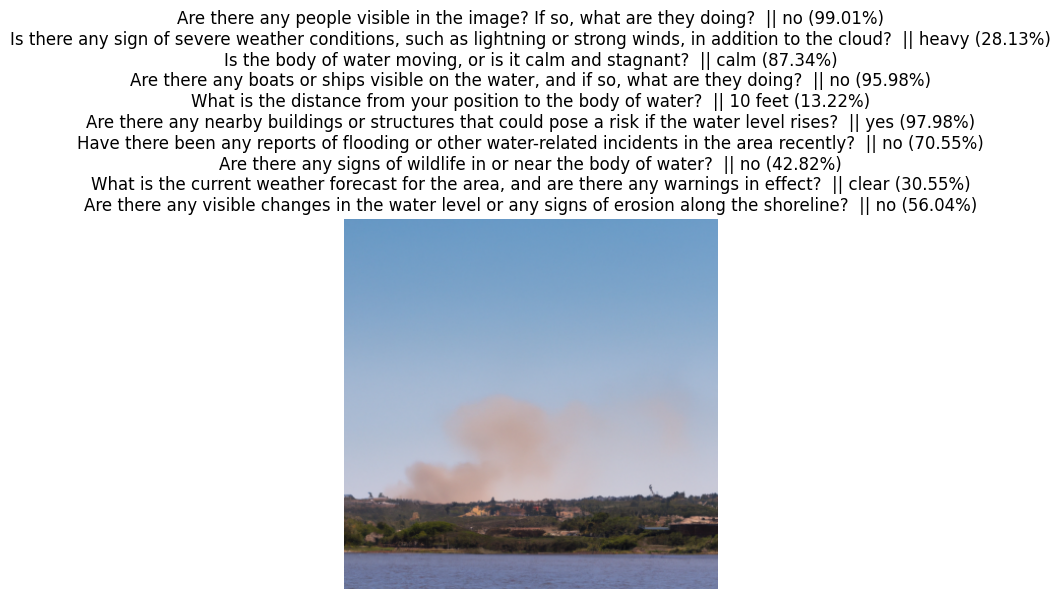

In [17]:
title = ''
image_array_rgb = image_array[:, :, :3]

for follow_up_question in numbered_list:

    # prepare inputs
    encoding = vilt_processor(image_array_rgb, follow_up_question, return_tensors="pt")

    # forward pass
    outputs = vilt_model(**encoding)
    logits = outputs.logits
    idx = logits.argmax(-1).item()

    # apply softmax to get probabilities
    probabilities = torch.softmax(logits, dim=-1)
    predicted_probability = probabilities[0, idx].item()

    predicted_answer = vilt_model.config.id2label[idx]
    title += f"{follow_up_question} || {predicted_answer} ({predicted_probability:.2%})\n"
    print(f"{follow_up_question} || {predicted_answer} ({predicted_probability:.2%}")

# display image with the generated caption and probability
plt.imshow(image)
plt.title(title.strip())
plt.axis('off')
plt.show()